In [1]:
from config_figures import *
from scipy.stats import gaussian_kde
from math import floor, ceil

In [3]:
df = pd.read_csv(google_drive_path + '/' + sdms_area_lat_elev_drive_filename + '.csv').drop(['system:index', '.geo'], axis=1)
df

,area_1981_2010,area_2071_2100_ssp585,elevation_1981_2010,elevation_2071_2100_ssp585,latitude_1981_2010,latitude_2071_2100_ssp585,species
0,9.416606e+11,4.994057e+11,271.175664,399.579457,3.628973,2.876506,Abarema_barbouriana
1,8.040583e+11,3.847494e+12,583.798649,263.647537,-20.127242,-9.120274,Abarema_brachystachya
2,5.791520e+11,2.033590e+12,46.901477,111.744412,-2.438856,-2.375266,Abarema_cochleata
3,3.037458e+11,7.531232e+11,251.950137,275.758666,-12.438020,-23.436968,Abarema_filamentosa
4,3.035330e+12,3.245311e+12,199.640084,167.579015,2.124966,0.123486,Abarema_jupunba
...,...,...,...,...,...,...,...
10585,4.536488e+12,5.360228e+12,179.666668,199.549619,-0.876385,-2.251095,Zygia_latifolia
10586,1.311062e+12,9.454284e+11,239.455205,303.168667,5.378190,5.373069,Zygia_longifolia
10587,1.998093e+12,4.274584e+12,135.571138,135.514965,0.374126,-2.625524,Zygia_racemosa
10588,2.838407e+12,6.741721e+12,111.851514,175.216714,-0.874904,-2.375378,Zygia_unifoliolata


In [12]:
df = df[df['area_1981_2010'] != 0]
df['area_1981_2010_1e6km2'] = df['area_1981_2010'] / 1e12
print(df.shape)

(10590, 8)


In [13]:
df

,area_1981_2010,area_2071_2100_ssp585,elevation_1981_2010,elevation_2071_2100_ssp585,latitude_1981_2010,latitude_2071_2100_ssp585,species,area_1981_2010_1e6km2
0,9.416606e+11,4.994057e+11,271.175664,399.579457,3.628973,2.876506,Abarema_barbouriana,0.941661
1,8.040583e+11,3.847494e+12,583.798649,263.647537,-20.127242,-9.120274,Abarema_brachystachya,0.804058
2,5.791520e+11,2.033590e+12,46.901477,111.744412,-2.438856,-2.375266,Abarema_cochleata,0.579152
3,3.037458e+11,7.531232e+11,251.950137,275.758666,-12.438020,-23.436968,Abarema_filamentosa,0.303746
4,3.035330e+12,3.245311e+12,199.640084,167.579015,2.124966,0.123486,Abarema_jupunba,3.035330
...,...,...,...,...,...,...,...,...
10585,4.536488e+12,5.360228e+12,179.666668,199.549619,-0.876385,-2.251095,Zygia_latifolia,4.536488
10586,1.311062e+12,9.454284e+11,239.455205,303.168667,5.378190,5.373069,Zygia_longifolia,1.311062
10587,1.998093e+12,4.274584e+12,135.571138,135.514965,0.374126,-2.625524,Zygia_racemosa,1.998093
10588,2.838407e+12,6.741721e+12,111.851514,175.216714,-0.874904,-2.375378,Zygia_unifoliolata,2.838407


In [21]:
# step = 1

# print(floor(df['latitude_1981_2010'].min()), ceil(df['latitude_1981_2010'].max()))

# y_avg = np.arange(floor(df['latitude_1981_2010'].min()), ceil(df['latitude_1981_2010'].max()), step)
# x_avg = [df[(df['latitude_1981_2010'] >= lat) & (df['latitude_1981_2010'] < lat+step)]['area_1981_2010_1e6km2'].median() for lat in y_avg]
# x_q25 = [df[(df['latitude_1981_2010'] >= lat) & (df['latitude_1981_2010'] < lat+step)]['area_1981_2010_1e6km2'].quantile(0.25) for lat in y_avg]
# x_q75 = [df[(df['latitude_1981_2010'] >= lat) & (df['latitude_1981_2010'] < lat+step)]['area_1981_2010_1e6km2'].quantile(0.75) for lat in y_avg]

-50 68


In [26]:
step = 1#0.1
window = 3#0

latitudes = np.arange(floor(df['latitude_1981_2010'].min()), ceil(df['latitude_1981_2010'].max()), step)
median_area = [df[(df['latitude_1981_2010'] >= lat) & (df['latitude_1981_2010'] < lat+step)]['area_1981_2010_1e6km2'].median() for lat in latitudes]

rolling_average_df = pd.DataFrame(data={'lat': latitudes, 'median_area': median_area}, index=None)
rolling_average_df['rolling_average'] = rolling_average_df.median_area.rolling(window).mean()
rolling_average_df

,lat,median_area,rolling_average
0,-50,0.444041,NaN
1,-49,0.471087,NaN
2,-48,0.664331,0.526486
3,-47,0.358205,0.497874
4,-46,0.374591,0.465709
...,...,...,...
113,63,3.595352,NaN
114,64,1.502043,NaN
115,65,5.024268,3.373888
116,66,NaN,NaN


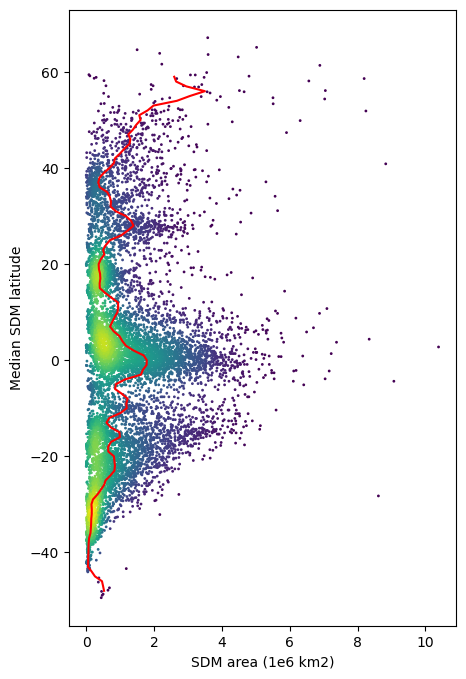

In [29]:
x = df['area_1981_2010_1e6km2']
y = df['latitude_1981_2010']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig=plt.figure(figsize=(5,8))
plt.scatter(x, y, c=z, s=1)
plt.set_cmap('viridis')
plt.plot(rolling_average_df['rolling_average'], rolling_average_df['lat'], 'r')

plt.ylabel('Median SDM latitude')
plt.xlabel('SDM area (1e6 km2)')
#plt.show()
plt.savefig('../figures/area_latitude_scatterplot_global.png')

In [146]:
df[(df['area_1981_2010_1e6km2'] > 6) & (df['medianlat_1981_2010'] < 10)].drop(['area_2071_2100_ssp585', 'medianlat_2071_2100_ssp585'], axis = 1).sort_values('area_1981_2010_1e6km2')

,area_1981_2010,medianlat_1981_2010,species,area_1981_2010_1e6km2
7204,6.107634e+12,-4.374031,Ouratea_ferruginea,6.107634
10222,6.119196e+12,-2.247404,Vachellia_tortilis,6.119196
9093,6.183439e+12,8.761980,Senegalia_senegal,6.183439
2455,6.188421e+12,-2.124157,Combretum_paraguariense,6.188421
9574,6.384760e+12,0.873177,Symphonia_globulifera,6.384760
2463,6.414274e+12,-5.125611,Commiphora_africana,6.414274
7593,6.498390e+12,5.877451,Piliostigma_thonningii,6.498390
9296,6.701454e+12,6.750528,Solanum_incanum,6.701454
10218,6.879708e+12,9.750764,Vachellia_seyal,6.879708
3146,7.044742e+12,-3.874852,Deguelia_amazonica,7.044742
